In [1]:
import io
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
import numpy as np

In [2]:
import pandas as pd
import numpy as np
import random
import re, string
from konlpy.tag import Komoran, Hannanum
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from keybert import KeyBERT

In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [67]:
df1 = pd.read_csv('data/머니투데이_샘플데이터(50,374개).csv')
df2 = pd.read_csv('data/매일경제_샘플데이터(41,319개).csv')

### 뉴스 전처리

In [ ]:
news_df = pd.concat([df1[:20000], df2[:20000]])

In [7]:
news_df =pd.read_csv('1cluster_df.csv')

In [8]:
news_df.head(3)

,Unnamed: 0.1,Unnamed: 0,TITLE,DATE,PRESS,REPORTER,CONTENT,noun,noun2,cluster1st
0,0,0,"'만우절같은 하루'...전국이 산불로 홍역, 화재 20여건 발생",2023-04-01 22:28:41,머니투데이,배한님 기자,\n\t\t\t산림청에 신고된 화재 16건 달해…전국에 소각산불 특보 발령\n\n\...,만우절 하루 전국 산불 홍역 화재 여건 발생,산림청 신고 화재 전국 소각 산불 특보 발령 오후 전남 해남군 옥천면 야산 발생 산...,0
1,1,1,"강남 한복판 ""살려주세요""…40대女 납치·살해범들 구속영장",2023-04-01 22:17:32,머니투데이,김지은 기자,\n\n\n\n\n납치 용의자들이 지난달 29일 밤 11시46분쯤 서울 역삼동의 한...,강남 한복판 납치 살해범 구속영장,납치 용의자 지난달 서울 역삼동 아파트 입구 피해 여성 차량 납치 영상 독자 제공 ...,1
2,2,2,"주키니 호박의 배신…미승인 유전자 검출, 식약처 2개 제품 압류",2023-04-01 21:21:39,머니투데이,지영호 기자,\n\n\n\n\n국내에서 생산된 주키니 호박 종자 일부가 승인되지 않은 유전자 변...,호박 배신 승인 유전자 검출 제품 압류,국내 생산 호박 종자 일부 승인 유전자 변형 생물체 확인 긴급 대응 사진 호박 식품...,2


In [4]:
#불용어 사전 만들기
stopwords = pd.read_csv("https://raw.githubusercontent.com/yoonkt200/FastCampusDataset/master/korean_stopwords.txt").values.tolist()
stopwords[:10]

[['휴'],
 ['아이구'],
 ['아이쿠'],
 ['아이고'],
 ['어'],
 ['나'],
 ['우리'],
 ['저희'],
 ['따라'],
 ['의해']]

In [5]:
komoran = Komoran()
hannanum = Hannanum()
# https://velog.io/@metterian/한국어-형태소-분석기POS-분석-3편.-형태소-분석기-비교
# https://konlpy.org/ko/v0.4.3/morph/#comparison-between-pos-tagging-classes

In [80]:
# 정규화
def preprocess(text):
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', ' ', str(text).strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text


# 명사/영단어 추출, 한글자 제외, 불용어 제거
def final(text):
    n = []
    word = komoran.nouns(text)
    p = komoran.pos(text)
    for pos in p:
      if pos[1] in ['SL']:
        word.append(pos[0])
    for w in word:
      if len(w)>1 and w not in stopwords:
        n.append(w)
    return " ".join(n)

# 최종
def finalpreprocess(text):
  return final(preprocess(text))


In [81]:
news_df['noun'] = news_df['TITLE'].apply(lambda x: finalpreprocess(x))
news_df['noun2'] = news_df['CONTENT'].apply(lambda x: finalpreprocess(x))
news_df.head()

,Unnamed: 0.1,Unnamed: 0,TITLE,DATE,PRESS,REPORTER,CONTENT,noun,noun2,cluster1st
0,0,0,"'만우절같은 하루'...전국이 산불로 홍역, 화재 20여건 발생",2023-04-01 22:28:41,머니투데이,배한님 기자,\n\t\t\t산림청에 신고된 화재 16건 달해…전국에 소각산불 특보 발령\n\n\...,만우절 하루 전국 산불 홍역 화재 여건 발생,산림청 신고 화재 전국 소각 산불 특보 발령 오후 전남 해남군 옥천면 야산 발생 산...,0
1,1,1,"강남 한복판 ""살려주세요""…40대女 납치·살해범들 구속영장",2023-04-01 22:17:32,머니투데이,김지은 기자,\n\n\n\n\n납치 용의자들이 지난달 29일 밤 11시46분쯤 서울 역삼동의 한...,강남 한복판 납치 살해범 구속영장,납치 용의자 지난달 서울 역삼동 아파트 입구 피해 여성 차량 납치 영상 독자 제공 ...,1
2,2,2,"주키니 호박의 배신…미승인 유전자 검출, 식약처 2개 제품 압류",2023-04-01 21:21:39,머니투데이,지영호 기자,\n\n\n\n\n국내에서 생산된 주키니 호박 종자 일부가 승인되지 않은 유전자 변...,호박 배신 승인 유전자 검출 제품 압류,국내 생산 호박 종자 일부 승인 유전자 변형 생물체 확인 긴급 대응 사진 호박 식품...,2
3,3,3,"""폭탄 들고 서문시장 간다""…尹 겨냥한 테러 암시글에 경찰 조사 중",2023-04-01 21:13:25,머니투데이,배한님 기자,\n\n\n\n\n윤석열 대통령과 부인 김건희 여사가 1일 대구 서문시장에서 열린 ...,폭탄 서문시장 간다 겨냥 테러 암시 경찰 조사,윤석열 대통령 부인 김건희 여사 대구 서문시장 서문시장 주년 기념식 참석 시민 인사...,3
4,5,5,"1061회 로또, 당첨번호 4·24·27·35·37·45…보너스 번호 '15'",2023-04-01 20:48:00,머니투데이,배한님 기자,\n\n\n\n\n/사진=동행복권 홈페이지 갈무리로또복권을 운영 중인 동행복권은 제...,당첨 번호 보너스 번호,사진 동행 복권 홈페이지 갈무리 복권 운영 동행 복권 복권 추첨 번호 보너스 번호,4


In [14]:
news_df.shape

(40000, 7)

In [9]:
def extract_row(train, user_keyword):  #train은 dataframe

		# join함수를 이용하여 이어주고 contains 함수에 넣기
		user_keywords = '|'.join(user_keyword)
		temp = train[train['noun'].str.contains(user_keywords)]
		train_extract = temp[['TITLE']]
		train_extract
		return train_extract

# 한나눔 전처리
def final_han(text):
    n = []
    word = hannanum.nouns(text)
    p = hannanum.pos(text)
    for pos in p:
      if pos[1] in ['F']:
        word.append(pos[0])
    for w in word:
      if len(w)>1 and w not in stopwords:
        n.append(w)
    return " ".join(n)

# 최종
def finalpreprocess_han(text):
  return final_han(preprocess(text))

### 1차 군집화(중복 기사 제거)

In [10]:
data_extract = news_df[:]
# data_extract['noun'] = data_extract['TITLE'].apply(lambda x: finalpreprocess_han(x))
data_extract.head(3)

,Unnamed: 0.1,Unnamed: 0,TITLE,DATE,PRESS,REPORTER,CONTENT,noun,noun2,cluster1st
0,0,0,"'만우절같은 하루'...전국이 산불로 홍역, 화재 20여건 발생",2023-04-01 22:28:41,머니투데이,배한님 기자,\n\t\t\t산림청에 신고된 화재 16건 달해…전국에 소각산불 특보 발령\n\n\...,만우절 하루 전국 산불 홍역 화재 여건 발생,산림청 신고 화재 전국 소각 산불 특보 발령 오후 전남 해남군 옥천면 야산 발생 산...,0
1,1,1,"강남 한복판 ""살려주세요""…40대女 납치·살해범들 구속영장",2023-04-01 22:17:32,머니투데이,김지은 기자,\n\n\n\n\n납치 용의자들이 지난달 29일 밤 11시46분쯤 서울 역삼동의 한...,강남 한복판 납치 살해범 구속영장,납치 용의자 지난달 서울 역삼동 아파트 입구 피해 여성 차량 납치 영상 독자 제공 ...,1
2,2,2,"주키니 호박의 배신…미승인 유전자 검출, 식약처 2개 제품 압류",2023-04-01 21:21:39,머니투데이,지영호 기자,\n\n\n\n\n국내에서 생산된 주키니 호박 종자 일부가 승인되지 않은 유전자 변...,호박 배신 승인 유전자 검출 제품 압류,국내 생산 호박 종자 일부 승인 유전자 변형 생물체 확인 긴급 대응 사진 호박 식품...,2


In [11]:
data_extract = data_extract.dropna()

In [12]:
text = data_extract['noun']

In [6]:
#1 tf-idf 임베딩(+Normalize)
def tfidf_vectorizer(text, min_df=3, ngram_range=(1,5)):
    tfidf_vectorizer = TfidfVectorizer(min_df = 3, ngram_range=(1,5)) #min_df :최소 빈도값 (단어 등장하는 문서 수)
    tfidf_vectorizer.fit(text)
    vector = tfidf_vectorizer.transform(text).toarray()
    vector = np.array(vector) # Normalizer를 이용해 이미 변환된 벡터
    return vector

In [ ]:
vector_1st = tfidf_vectorizer(text, min_df=1)

In [14]:
#2 DBSCAN Clustering #11m
model = DBSCAN(eps=0.1,min_samples=1, metric = "cosine") 
# 거리 계산 식으로는 Cosine distance를 이용
# eps이 낮을수록, min_samples 값이 높을수록 군집으로 판단하는 기준이 까다로움.
result_1st = model.fit_predict(vector_1st)
data_extract['cluster1st'] = result_1st

print('군집개수 :', result_1st.max())
data_extract

군집개수 : 38641


,Unnamed: 0,TITLE,DATE,PRESS,REPORTER,CONTENT,noun,noun2,cluster1st
0,0,"'만우절같은 하루'...전국이 산불로 홍역, 화재 20여건 발생",2023-04-01 22:28:41,머니투데이,배한님 기자,\n\t\t\t산림청에 신고된 화재 16건 달해…전국에 소각산불 특보 발령\n\n\...,만우절 하루 전국 산불 홍역 화재 여건 발생,산림청 신고 화재 전국 소각 산불 특보 발령 오후 전남 해남군 옥천면 야산 발생 산...,0
1,1,"강남 한복판 ""살려주세요""…40대女 납치·살해범들 구속영장",2023-04-01 22:17:32,머니투데이,김지은 기자,\n\n\n\n\n납치 용의자들이 지난달 29일 밤 11시46분쯤 서울 역삼동의 한...,강남 한복판 납치 살해범 구속영장,납치 용의자 지난달 서울 역삼동 아파트 입구 피해 여성 차량 납치 영상 독자 제공 ...,1
2,2,"주키니 호박의 배신…미승인 유전자 검출, 식약처 2개 제품 압류",2023-04-01 21:21:39,머니투데이,지영호 기자,\n\n\n\n\n국내에서 생산된 주키니 호박 종자 일부가 승인되지 않은 유전자 변...,호박 배신 승인 유전자 검출 제품 압류,국내 생산 호박 종자 일부 승인 유전자 변형 생물체 확인 긴급 대응 사진 호박 식품...,2
3,3,"""폭탄 들고 서문시장 간다""…尹 겨냥한 테러 암시글에 경찰 조사 중",2023-04-01 21:13:25,머니투데이,배한님 기자,\n\n\n\n\n윤석열 대통령과 부인 김건희 여사가 1일 대구 서문시장에서 열린 ...,폭탄 서문시장 간다 겨냥 테러 암시 경찰 조사,윤석열 대통령 부인 김건희 여사 대구 서문시장 서문시장 주년 기념식 참석 시민 인사...,3
5,5,"1061회 로또, 당첨번호 4·24·27·35·37·45…보너스 번호 '15'",2023-04-01 20:48:00,머니투데이,배한님 기자,\n\n\n\n\n/사진=동행복권 홈페이지 갈무리로또복권을 운영 중인 동행복권은 제...,당첨 번호 보너스 번호,사진 동행 복권 홈페이지 갈무리 복권 운영 동행 복권 복권 추첨 번호 보너스 번호,4
...,...,...,...,...,...,...,...,...,...
39995,19995,내일 오후부터 전국 눈 또는 비 소식…미세먼지 나쁨,2023-01-05 22:56:01,매일경제,맹성규 기자,\n\n\n\n\n 새하얀 도심 - 한파가 이어지는 지난달 28일 서울 광나루한강공...,내일 오후 전국 소식 미세먼지,도심 한파 지난달 서울 광나루한강공원 한강 새벽 중부 지방 사진 출처 연합뉴스 절기...,38637
39996,19996,‘255억 계약’ 英왕자의 폭로 “형 공격에 개밥그릇 파편 박혀”,2023-01-05 22:52:01,매일경제,맹성규 기자,\n\n\n\n\n 해리 왕자(왼쪽)와 윌리엄 왕자가 2021년 런던 켄싱턴궁에서 ...,계약 왕자 폭로 공격 밥그릇 파편,해리 왕자 왼쪽 윌리엄 왕자 런던 켄싱턴궁 어머니 다이애나 왕세자비 동상 제막식 참...,38638
39997,19997,"도망쳤던 중국인 확진자, 서울서 이틀동안 활보…아내와 호텔서 은신",2023-01-05 22:49:01,매일경제,최기성 기자,\n\n\n\n\n 격리 거부하고 도주했다가 검거된 중국인 확진자 [사진출처=연합뉴...,중국인 확진 서울 이틀 동안 활보 아내 호텔 은신,격리 거부 도주 검거 중국인 확진 사진 출처 연합뉴스 코로나 확진 판정 격리 거부 ...,38639
39998,19998,“살아있기를 빌었는데”…‘콘크리트기둥 추락’ 베트남 소년 구조 포기,2023-01-05 22:29:01,매일경제,최기성 기자,\n\n\n\n\n 콘크리트 기둥에 빠진 소년이 사망했다고 발표하는 도안 떤 부 통...,콘크리트 기둥 추락 베트남 소년 구조 포기,콘크리트 기둥 소년 사망 발표 도안 부성장 사진 출처 익스프레스 캡처 베트남 동 고...,38640


In [13]:
def print_cluster_result(train, result, col_cluster):
    # train : 데이터, result : 군집화 결과, col_cluster : 클러스터넘버 컬럼명
    clusters = []
    counts = []
    titles = []
    urls = []
    thumbnails = []
    nouns = []
    
    for cluster_num in set(result):
            print("cluster num : {}".format(cluster_num))
            temp_df = train[train[col_cluster] == cluster_num] # cluster num 별로 조회
            clusters.append(cluster_num)
            counts.append(len(temp_df))
            titles.append(temp_df.reset_index()['TITLE'][0])

            if len(temp_df) == 1: 
                nouns.append(temp_df.reset_index()['noun'][0]) 
            else:
                words = temp_df['noun'].str.split(expand=True).stack().value_counts()
                duplicates = words[words > 2].index.tolist()
                nounwords = ' '.join(set(duplicates)) 
                nouns.append(nounwords) 
                 
            for title in temp_df['TITLE']:
                print(title) # 제목으로 살펴보자
            print()

    cluster_result = pd.DataFrame({'cluster_num':clusters, 'count':counts, 'TITLE': titles, 'noun': nouns})
    return cluster_result

In [ ]:
cluster1_result = print_cluster_result(train=data_extract, 
                                       result=result_1st, col_cluster="cluster1st")

In [17]:
data_extract.to_csv('1cluster_df.csv')

### 토픽 모델링

In [4]:
cluster1_result = pd.read_csv('1cluster_df.csv')
cluster1_result = cluster1_result.dropna()
cluster1_result.head(3)

,Unnamed: 0.1,Unnamed: 0,TITLE,DATE,PRESS,REPORTER,CONTENT,noun,noun2,cluster1st
0,0,0,"'만우절같은 하루'...전국이 산불로 홍역, 화재 20여건 발생",2023-04-01 22:28:41,머니투데이,배한님 기자,\n\t\t\t산림청에 신고된 화재 16건 달해…전국에 소각산불 특보 발령\n\n\...,만우절 하루 전국 산불 홍역 화재 여건 발생,산림청 신고 화재 전국 소각 산불 특보 발령 오후 전남 해남군 옥천면 야산 발생 산...,0
1,1,1,"강남 한복판 ""살려주세요""…40대女 납치·살해범들 구속영장",2023-04-01 22:17:32,머니투데이,김지은 기자,\n\n\n\n\n납치 용의자들이 지난달 29일 밤 11시46분쯤 서울 역삼동의 한...,강남 한복판 납치 살해범 구속영장,납치 용의자 지난달 서울 역삼동 아파트 입구 피해 여성 차량 납치 영상 독자 제공 ...,1
2,2,2,"주키니 호박의 배신…미승인 유전자 검출, 식약처 2개 제품 압류",2023-04-01 21:21:39,머니투데이,지영호 기자,\n\n\n\n\n국내에서 생산된 주키니 호박 종자 일부가 승인되지 않은 유전자 변...,호박 배신 승인 유전자 검출 제품 압류,국내 생산 호박 종자 일부 승인 유전자 변형 생물체 확인 긴급 대응 사진 호박 식품...,2


#### LDA

In [5]:
cluster1_result = cluster1_result[['TITLE','DATE','PRESS','REPORTER','CONTENT','noun','noun2','cluster1st']]
cluster1_result.head(3)

,TITLE,DATE,PRESS,REPORTER,CONTENT,noun,noun2,cluster1st
0,"'만우절같은 하루'...전국이 산불로 홍역, 화재 20여건 발생",2023-04-01 22:28:41,머니투데이,배한님 기자,\n\t\t\t산림청에 신고된 화재 16건 달해…전국에 소각산불 특보 발령\n\n\...,만우절 하루 전국 산불 홍역 화재 여건 발생,산림청 신고 화재 전국 소각 산불 특보 발령 오후 전남 해남군 옥천면 야산 발생 산...,0
1,"강남 한복판 ""살려주세요""…40대女 납치·살해범들 구속영장",2023-04-01 22:17:32,머니투데이,김지은 기자,\n\n\n\n\n납치 용의자들이 지난달 29일 밤 11시46분쯤 서울 역삼동의 한...,강남 한복판 납치 살해범 구속영장,납치 용의자 지난달 서울 역삼동 아파트 입구 피해 여성 차량 납치 영상 독자 제공 ...,1
2,"주키니 호박의 배신…미승인 유전자 검출, 식약처 2개 제품 압류",2023-04-01 21:21:39,머니투데이,지영호 기자,\n\n\n\n\n국내에서 생산된 주키니 호박 종자 일부가 승인되지 않은 유전자 변...,호박 배신 승인 유전자 검출 제품 압류,국내 생산 호박 종자 일부 승인 유전자 변형 생물체 확인 긴급 대응 사진 호박 식품...,2


In [6]:
cluster1_result['noun1'] =cluster1_result['noun'].str.split(" ")
cluster1_result['noun3'] =cluster1_result['noun2'].str.split(" ")
cluster1_result.head(3)

,TITLE,DATE,PRESS,REPORTER,CONTENT,noun,noun2,cluster1st,noun1,noun3
0,"'만우절같은 하루'...전국이 산불로 홍역, 화재 20여건 발생",2023-04-01 22:28:41,머니투데이,배한님 기자,\n\t\t\t산림청에 신고된 화재 16건 달해…전국에 소각산불 특보 발령\n\n\...,만우절 하루 전국 산불 홍역 화재 여건 발생,산림청 신고 화재 전국 소각 산불 특보 발령 오후 전남 해남군 옥천면 야산 발생 산...,0,"[만우절, 하루, 전국, 산불, 홍역, 화재, 여건, 발생]","[산림청, 신고, 화재, 전국, 소각, 산불, 특보, 발령, 오후, 전남, 해남군,..."
1,"강남 한복판 ""살려주세요""…40대女 납치·살해범들 구속영장",2023-04-01 22:17:32,머니투데이,김지은 기자,\n\n\n\n\n납치 용의자들이 지난달 29일 밤 11시46분쯤 서울 역삼동의 한...,강남 한복판 납치 살해범 구속영장,납치 용의자 지난달 서울 역삼동 아파트 입구 피해 여성 차량 납치 영상 독자 제공 ...,1,"[강남, 한복판, 납치, 살해범, 구속영장]","[납치, 용의자, 지난달, 서울, 역삼동, 아파트, 입구, 피해, 여성, 차량, 납..."
2,"주키니 호박의 배신…미승인 유전자 검출, 식약처 2개 제품 압류",2023-04-01 21:21:39,머니투데이,지영호 기자,\n\n\n\n\n국내에서 생산된 주키니 호박 종자 일부가 승인되지 않은 유전자 변...,호박 배신 승인 유전자 검출 제품 압류,국내 생산 호박 종자 일부 승인 유전자 변형 생물체 확인 긴급 대응 사진 호박 식품...,2,"[호박, 배신, 승인, 유전자, 검출, 제품, 압류]","[국내, 생산, 호박, 종자, 일부, 승인, 유전자, 변형, 생물체, 확인, 긴급,..."


In [7]:
data_word = cluster1_result['noun3']

In [9]:
from gensim import corpora

In [10]:
from konlpy.tag import Mecab
from tqdm import tqdm
import re
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import CoherenceMetric
from gensim import corpora
from gensim.models.callbacks import PerplexityMetric
import logging
import pickle
import pyLDAvis.gensim
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [11]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=10):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [12]:
def find_optimal_number_of_topics(dictionary, corpus, processed_data):
    limit = 40;
    start = 2;
    step = 6;

    model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=processed_data, start=start, limit=limit, step=step)

    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    print(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

2023-05-11 13:33:46,422 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2023-05-11 13:33:47,958 : INFO : adding document #10000 to Dictionary(43939 unique tokens: ['DB', '강원', '강원도', '강화', '강화군']...)
2023-05-11 13:33:49,451 : INFO : adding document #20000 to Dictionary(56835 unique tokens: ['DB', '강원', '강원도', '강화', '강화군']...)
2023-05-11 13:33:51,192 : INFO : adding document #30000 to Dictionary(66425 unique tokens: ['DB', '강원', '강원도', '강화', '강화군']...)
2023-05-11 13:33:52,905 : INFO : built Dictionary(73907 unique tokens: ['DB', '강원', '강원도', '강화', '강화군']...) from 39960 documents (total 7575532 corpus positions)
2023-05-11 13:33:52,994 : INFO : discarding 51885 tokens: [('강화', 5861), ('경기', 4032), ('경우', 8158), ('고탄리', 1), ('곤지암읍', 1), ('공리', 5), ('국가', 4910), ('금지', 3360), ('기간', 5758), ('기산면', 1)]...
2023-05-11 13:33:52,996 : INFO : keeping 22022 tokens which were in no less than 10 and no more than 1998 (=5.0%) documents
2023-05-11 13:33:53,046 : INFO : resulting dictio

Number of unique tokens: 22022
Number of documents: 39960


2023-05-11 13:33:56,904 : INFO : merging changes from 2000 documents into a model of 39960 documents
2023-05-11 13:33:56,911 : INFO : topic #0 (0.500): 0.003*"대출" + 0.003*"재산" + 0.002*"지수" + 0.002*"의료" + 0.002*"러시아" + 0.002*"민주당" + 0.002*"민간" + 0.002*"위원" + 0.002*"스타트" + 0.001*"환자"
2023-05-11 13:33:56,912 : INFO : topic #1 (0.500): 0.002*"선임" + 0.002*"배터리" + 0.002*"사장" + 0.002*"주주" + 0.002*"대출" + 0.002*"뉴시스" + 0.002*"부산" + 0.001*"지수" + 0.001*"이사회" + 0.001*"승인"
2023-05-11 13:33:56,913 : INFO : topic diff=2.658497, rho=1.000000
2023-05-11 13:33:56,914 : INFO : PROGRESS: pass 0, at document #4000/39960
2023-05-11 13:33:57,794 : INFO : merging changes from 2000 documents into a model of 39960 documents
2023-05-11 13:33:57,798 : INFO : topic #0 (0.500): 0.003*"대출" + 0.003*"민주당" + 0.002*"의료" + 0.002*"환자" + 0.002*"우주" + 0.002*"러시아" + 0.002*"접종" + 0.002*"치료" + 0.002*"한일" + 0.002*"바이오"
2023-05-11 13:33:57,799 : INFO : topic #1 (0.500): 0.002*"배터리" + 0.002*"인수" + 0.002*"건설" + 0.002*"공장" + 0.002*

range(2, 40, 6) [0.3138071429130228, 0.5924911619402277, 0.6043377730331841, 0.5210576498451523, 0.583408793165504, 0.5579311321311062, 0.5686883277194964]


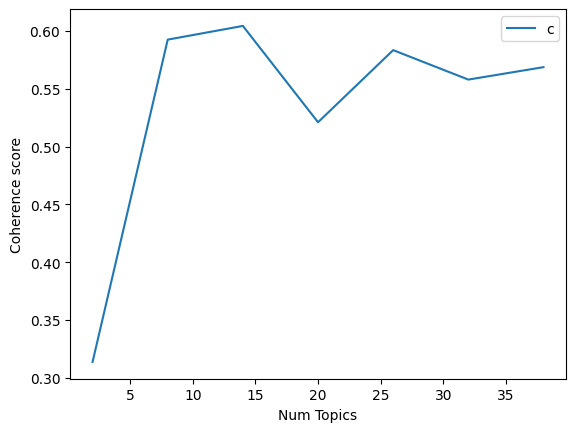

In [18]:
# if __name__ == '__main__':
# data_word = [sent.strip().split(",") for sent in tqdm(open('./data/tokenized_data.csv', 'r', encoding='utf-8').readlines())]

# 정수 인코딩과 빈도수 생성
dictionary = corpora.Dictionary(data_word)

# 출현빈도가 적거나 자주 등장하는 단어는 제거
dictionary.filter_extremes(no_below=10, no_above=0.05)
corpus = [dictionary.doc2bow(text) for text in data_word]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# 최적의 토픽 수 찾기
find_optimal_number_of_topics(dictionary, corpus, data_word)

In [19]:
from konlpy.tag import Mecab
from tqdm import tqdm
import re
from gensim.models.ldamodel import LdaModel
from gensim.models.callbacks import CoherenceMetric
from gensim import corpora
from gensim.models.callbacks import PerplexityMetric
import logging
import pickle
import pyLDAvis.gensim
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

In [20]:
# 정수 인코딩과 빈도수 생성
dictionary = corpora.Dictionary(data_word)

# 출현빈도가 적거나 자주 등장하는 단어는 제거
dictionary.filter_extremes(no_below=10, no_above=0.05)
corpus = [dictionary.doc2bow(text) for text in data_word]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

2023-05-11 14:32:35,407 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2023-05-11 14:32:36,936 : INFO : adding document #10000 to Dictionary(43939 unique tokens: ['DB', '강원', '강원도', '강화', '강화군']...)
2023-05-11 14:32:38,526 : INFO : adding document #20000 to Dictionary(56835 unique tokens: ['DB', '강원', '강원도', '강화', '강화군']...)
2023-05-11 14:32:40,307 : INFO : adding document #30000 to Dictionary(66425 unique tokens: ['DB', '강원', '강원도', '강화', '강화군']...)
2023-05-11 14:32:41,957 : INFO : built Dictionary(73907 unique tokens: ['DB', '강원', '강원도', '강화', '강화군']...) from 39960 documents (total 7575532 corpus positions)
2023-05-11 14:32:42,020 : INFO : discarding 51885 tokens: [('강화', 5861), ('경기', 4032), ('경우', 8158), ('고탄리', 1), ('곤지암읍', 1), ('공리', 5), ('국가', 4910), ('금지', 3360), ('기간', 5758), ('기산면', 1)]...
2023-05-11 14:32:42,021 : INFO : keeping 22022 tokens which were in no less than 10 and no more than 1998 (=5.0%) documents
2023-05-11 14:32:42,056 : INFO : resulting dictio

Number of unique tokens: 22022
Number of documents: 39960


In [15]:
# find_optimal_number_of_topics(dictionary, corpus, data_word)
# exit()

perplexity_logger = PerplexityMetric(corpus=corpus, logger='shell')
coherence_logger = CoherenceMetric(corpus=corpus, coherence="u_mass", logger='shell')

lda_model = LdaModel(corpus, id2word=dictionary, num_topics=15, passes=30, callbacks=[coherence_logger, perplexity_logger])

topics = lda_model.print_topics(num_words=20)
for topic in topics:
    print(topic)

2023-05-11 14:16:13,458 : INFO : using symmetric alpha at 0.06666666666666667
2023-05-11 14:16:13,461 : INFO : using symmetric eta at 0.06666666666666667
2023-05-11 14:16:13,464 : INFO : using serial LDA version on this node
2023-05-11 14:16:13,490 : INFO : running online (multi-pass) LDA training, 15 topics, 30 passes over the supplied corpus of 39960 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2023-05-11 14:16:13,492 : INFO : PROGRESS: pass 0, at document #2000/39960
2023-05-11 14:16:14,479 : INFO : merging changes from 2000 documents into a model of 39960 documents
2023-05-11 14:16:14,502 : INFO : topic #7 (0.067): 0.005*"접종" + 0.004*"백신" + 0.003*"의료" + 0.003*"통풍" + 0.003*"인신매매" + 0.003*"피해자" + 0.002*"변호사" + 0.002*"범죄" + 0.002*"재생" + 0.002*"부산"
2023-05-11 14:16:14,503 : INFO : topic #14 (0.067): 0.004*"ETF" + 0.003*"민간" + 0.003*"펀드" + 0.003*"기후" + 0.003*"대출" + 0.003*"탄소" + 0.

(0, '0.011*"애플" + 0.010*"우주" + 0.006*"대회" + 0.006*"선수" + 0.006*"장애인" + 0.006*"영국" + 0.006*"역사" + 0.005*"훈련" + 0.005*"이야기" + 0.005*"과학기술" + 0.005*"호주" + 0.005*"감독" + 0.005*"사랑" + 0.005*"생명" + 0.005*"촬영" + 0.005*"이름" + 0.005*"수상" + 0.004*"프로" + 0.004*"양자" + 0.004*"비행"')
(1, '0.019*"기차" + 0.015*"배터리" + 0.014*"주주" + 0.014*"SK" + 0.011*"현대차" + 0.011*"공장" + 0.011*"사장" + 0.010*"KT" + 0.010*"자동차" + 0.009*"지분" + 0.008*"법인" + 0.008*"인수" + 0.007*"테슬라" + 0.007*"LG" + 0.007*"선임" + 0.007*"이사회" + 0.006*"기아" + 0.006*"안철수" + 0.006*"포스코" + 0.005*"CEO"')
(2, '0.024*"아파트" + 0.023*"가구" + 0.017*"전세" + 0.014*"서울시" + 0.012*"분양" + 0.010*"단지" + 0.010*"청약" + 0.010*"공사" + 0.010*"도시" + 0.008*"임대" + 0.008*"건설" + 0.007*"주거" + 0.007*"보증금" + 0.006*"입주" + 0.006*"국토" + 0.006*"공공" + 0.006*"전용" + 0.006*"매매" + 0.006*"수도권" + 0.005*"재건축"')
(3, '0.023*"러시아" + 0.022*"북한" + 0.013*"전쟁" + 0.010*"안보" + 0.009*"총리" + 0.009*"인도" + 0.008*"영국" + 0.008*"외교" + 0.008*"미사일" + 0.008*"양국" + 0.007*"한일" + 0.007*"바이든" + 0.007*"공격" + 0.006*"독일" 

In [22]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_word, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score (c_v): ', coherence_lda)

# Compute Coherence Score using UMass
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_word, dictionary=dictionary, coherence="u_mass")
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score (u_mass): ', coherence_lda)

2023-05-11 14:32:56,289 : INFO : using ParallelWordOccurrenceAccumulator(processes=9, batch_size=64) to estimate probabilities from sliding windows
2023-05-11 14:33:03,864 : INFO : 1 batches submitted to accumulate stats from 64 documents (9175 virtual)
2023-05-11 14:33:03,870 : INFO : 2 batches submitted to accumulate stats from 128 documents (14615 virtual)
2023-05-11 14:33:03,874 : INFO : 3 batches submitted to accumulate stats from 192 documents (20385 virtual)
2023-05-11 14:33:03,882 : INFO : 4 batches submitted to accumulate stats from 256 documents (23611 virtual)
2023-05-11 14:33:03,895 : INFO : 5 batches submitted to accumulate stats from 320 documents (27128 virtual)
2023-05-11 14:33:03,902 : INFO : 6 batches submitted to accumulate stats from 384 documents (29940 virtual)
2023-05-11 14:33:03,911 : INFO : 7 batches submitted to accumulate stats from 448 documents (35394 virtual)
2023-05-11 14:33:03,918 : INFO : 8 batches submitted to accumulate stats from 512 documents (40934


Coherence Score (c_v):  0.6380884720837928


2023-05-11 14:33:15,702 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2023-05-11 14:33:15,719 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2023-05-11 14:33:15,734 : INFO : CorpusAccumulator accumulated stats from 3000 documents
2023-05-11 14:33:15,751 : INFO : CorpusAccumulator accumulated stats from 4000 documents
2023-05-11 14:33:15,768 : INFO : CorpusAccumulator accumulated stats from 5000 documents
2023-05-11 14:33:15,785 : INFO : CorpusAccumulator accumulated stats from 6000 documents
2023-05-11 14:33:15,803 : INFO : CorpusAccumulator accumulated stats from 7000 documents
2023-05-11 14:33:15,819 : INFO : CorpusAccumulator accumulated stats from 8000 documents
2023-05-11 14:33:15,837 : INFO : CorpusAccumulator accumulated stats from 9000 documents
2023-05-11 14:33:15,852 : INFO : CorpusAccumulator accumulated stats from 10000 documents
2023-05-11 14:33:15,870 : INFO : CorpusAccumulator accumulated stats from 11000 documents
2023-05-11 14:33:15


Coherence Score (u_mass):  -2.728045987438902


In [23]:
topics

[(0,
  '0.011*"애플" + 0.010*"우주" + 0.006*"대회" + 0.006*"선수" + 0.006*"장애인" + 0.006*"영국" + 0.006*"역사" + 0.005*"훈련" + 0.005*"이야기" + 0.005*"과학기술" + 0.005*"호주" + 0.005*"감독" + 0.005*"사랑" + 0.005*"생명" + 0.005*"촬영" + 0.005*"이름" + 0.005*"수상" + 0.004*"프로" + 0.004*"양자" + 0.004*"비행"'),
 (1,
  '0.019*"기차" + 0.015*"배터리" + 0.014*"주주" + 0.014*"SK" + 0.011*"현대차" + 0.011*"공장" + 0.011*"사장" + 0.010*"KT" + 0.010*"자동차" + 0.009*"지분" + 0.008*"법인" + 0.008*"인수" + 0.007*"테슬라" + 0.007*"LG" + 0.007*"선임" + 0.007*"이사회" + 0.006*"기아" + 0.006*"안철수" + 0.006*"포스코" + 0.005*"CEO"'),
 (2,
  '0.024*"아파트" + 0.023*"가구" + 0.017*"전세" + 0.014*"서울시" + 0.012*"분양" + 0.010*"단지" + 0.010*"청약" + 0.010*"공사" + 0.010*"도시" + 0.008*"임대" + 0.008*"건설" + 0.007*"주거" + 0.007*"보증금" + 0.006*"입주" + 0.006*"국토" + 0.006*"공공" + 0.006*"전용" + 0.006*"매매" + 0.006*"수도권" + 0.005*"재건축"'),
 (3,
  '0.023*"러시아" + 0.022*"북한" + 0.013*"전쟁" + 0.010*"안보" + 0.009*"총리" + 0.009*"인도" + 0.008*"영국" + 0.008*"외교" + 0.008*"미사일" + 0.008*"양국" + 0.007*"한일" + 0.007*"바이든" + 0.007*"공격

In [24]:
# 저장
# pickle.dump(corpus, open('./data/lda/lda_corpus.pkl', 'wb'))
dictionary.save('lda_dictionary.gensim')
lda_model.save('lda_model.gensim')

2023-05-11 14:35:41,305 : INFO : saving Dictionary object under lda_dictionary.gensim, separately None
2023-05-11 14:35:41,411 : INFO : saved lda_dictionary.gensim
2023-05-11 14:35:41,412 : INFO : saving LdaState object under lda_model.gensim.state, separately None
2023-05-11 14:35:41,425 : INFO : saved lda_model.gensim.state
2023-05-11 14:35:41,440 : INFO : saving LdaModel object under lda_model.gensim, separately ['expElogbeta', 'sstats']
2023-05-11 14:35:41,441 : INFO : storing np array 'expElogbeta' to lda_model.gensim.expElogbeta.npy
2023-05-11 14:35:41,445 : INFO : not storing attribute dispatcher
2023-05-11 14:35:41,446 : INFO : not storing attribute id2word
2023-05-11 14:35:41,446 : INFO : not storing attribute state
2023-05-11 14:35:42,785 : INFO : saved lda_model.gensim


In [25]:
# pyLDAvis html 저장
lda_visualization = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)
pyLDAvis.save_html(lda_visualization, '뉴스군집화_lda.html')

In [36]:
import pandas as pd

# 추론한 토픽 분포를 데이터프레임으로 저장
topics = []
for i, doc in enumerate(corpus):
    dist = lda_model.get_document_topics(doc, per_word_topics=False)
    highest_prob_topic = max(dist, key=lambda x: x[1])
    topic, prob = highest_prob_topic
    topics.append([i, topic, prob])
df = pd.DataFrame(topics, columns=['row', 'topic', 'prob'])

print(df.head())
print(df.shape)

   row  topic      prob
0    0     13  0.925711
1    1      4  0.951537
2    2      5  0.524442
3    3     12  0.353311
4    4     11  0.767117
(39960, 3)


In [ ]:
# 각 row의 내용을 데이터프레임에 추가
docs = []
for doc in corpus:
    tokens = [dictionary[word_id] for word_id, freq in doc]
    docs.append(' '.join(tokens))

df['document'] = docs
df['title'] = cluster1_result['TITLE']


In [45]:
# 결과 출력
df.head()

,row,topic,prob,document,title
0,0,13,0.925711,DB 강원 강원도 강화군 건조 경계 경기도 경남 경보 경북 경상남도 고온 곳곳 공동...,"'만우절같은 하루'...전국이 산불로 홍역, 화재 20여건 발생"
1,1,4,0.951537,진술 가담 가상 강남구 강도 강제 검거 검출 결론 경찰서 공모 구두 구속 구속영장 ...,"강남 한복판 ""살려주세요""…40대女 납치·살해범들 구속영장"
2,2,5,0.524442,지자체 검출 가공식품 가정 개사 검사 구입 기점 기한 긴급 당부 도매 돼지 마트 물...,"주키니 호박의 배신…미승인 유전자 검출, 식약처 2개 제품 압류"
3,3,12,0.353311,뉴시스 오늘 SNS 간다 개막전 게시 겨냥 계정 기념식 기자단 김건희 남부경찰서 대...,"""폭탄 들고 서문시장 간다""…尹 겨냥한 테러 암시글에 경찰 조사 중"
4,4,11,0.767117,갈무리 동행 번호 보너스 복권 추첨 홈페이지,"1061회 로또, 당첨번호 4·24·27·35·37·45…보너스 번호 '15'"


In [46]:
df.to_csv('news_clustering_0511.csv', encoding='utf-8-sig')